In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchvision.transforms import autoaugment
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import os
import csv
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = [file for file in os.listdir(img_dir) if file.endswith('.png')]
        self.transform = transform
        self.img_list.sort()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = f'{self.img_dir}{img_name}'
        image = np.array(Image.open(img_path))
        label = torch.tensor(int(img_name.split('_')[0]))
        if self.transform:
            image = self.transform(image)
        return image, label, img_name

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.ConvertImageDtype(torch.uint8),
                                      transforms.RandomHorizontalFlip(p=0.5),
#                                       transforms.RandomVerticalFlip(p=0.1),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                                       transforms.RandomGrayscale(p=0.1),
                                      transforms.RandomResizedCrop((288, 288), scale=(0.5, 1)),
#                                       transforms.RandomRotation((-30, 30), center=(144, 144)),
#                                       transforms.AutoAugment(policy=autoaugment.AutoAugmentPolicy('imagenet')),
                                      transforms.ConvertImageDtype(torch.float),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.ConvertImageDtype(torch.uint8),
                                     transforms.Resize((288, 288)),
                                     transforms.ConvertImageDtype(torch.float),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
train_img_dir = 'hw1_data/p1_data/train_50/'
test_img_dir = 'hw1_data/p1_data/val_50/'
batch_size = 128

In [5]:
train_data = ImageDataset(img_dir=train_img_dir, transform=train_transform)
test_data = ImageDataset(img_dir=test_img_dir, transform=test_transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
image, label, image_name = next(iter(test_dataloader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {label.size()}")
print(f"image_name batch shape: {len(image_name)}")

Feature batch shape: torch.Size([128, 3, 288, 288])
Labels batch shape: torch.Size([128])
image_name batch shape: 128


In [7]:
efficientnet_b2()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
class efficientnet_ft(nn.Module):
    def __init__(self):
        super(efficientnet_ft, self).__init__()
        base_model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(nn.Dropout(p=0.5),
                                        nn.Linear(1408, 50))
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model_ft = efficientnet_ft()
model_ft

efficientnet_ft(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActi

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# model_ft = torch.load('model_ft.pth')
model_ft.to(device)

best_model_ft = efficientnet_ft()
best_acc = 0.0
# best_acc = 0.85
# best_model_ft = torch.load('best_model_ft.pth')

record = {'train_loss':[], 'train_acc':[],'test_loss':[], 'test_acc':[]}
# record_load = np.load('record.npz')
# record['train_loss'] = record_load['train_loss'].tolist()
# record['train_acc'] = record_load['train_acc'].tolist()
# record['test_loss'] = record_load['test_loss'].tolist()
# record['test_acc'] = record_load['test_acc'].tolist()

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    train_loss, train_acc = 0, 0
    for batch, (X, y, n) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        batch_acc = (pred.argmax(1)==y).sum().item()
        train_acc += batch_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % step == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}, acc: {(100*batch_acc/batch_size):>0.1f}%  [{current:>5d}/{size:>5d}]")
    if scheduler is not None:
        scheduler.step()
    train_loss /= num_batches
    train_acc /= size
    print(f"Train | Avg_loss: {train_loss:>8f}, Accuracy: {(100*train_acc):>0.1f}%")
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y, n in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1)==y).sum().item()
    test_loss /= num_batches
    test_acc /= size
    print(f"Test  | Avg_loss: {test_loss:>8f}, Accuracy: {(100*test_acc):>0.1f}%\n")
    return test_loss, test_acc

In [11]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
epochs = 200
for e in range(1, epochs+1):
    ee = len(record['train_loss'])+1
    print(f"Epoch {ee}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_ft, loss_fn, optimizer, scheduler)
    test_loss, test_acc = test_loop(test_dataloader, model_ft, loss_fn)
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['test_loss'].append(test_loss)
    record['test_acc'].append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_ft.load_state_dict(model_ft.state_dict())
    if (ee%25 == 0) or (ee == 1):
        torch.save(model_ft, f'model_ft_{ee}.pth')
        torch.save(best_model_ft, f'best_model_ft.pth')
        np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
                 test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']))
print("Done!")

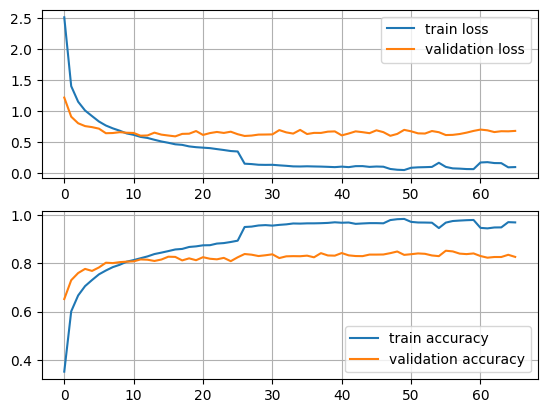

In [33]:
plt.figure()
plt.subplot(211)
plt.plot(np.arange(len(record['train_loss'])), record['train_loss'], np.arange(len(record['test_loss'])), record['test_loss'])
plt.legend(['train loss', 'validation loss'])
plt.grid()
plt.subplot(212)
plt.plot(np.arange(len(record['train_acc'])), record['train_acc'], np.arange(len(record['test_acc'])), record['test_acc'])
plt.legend(['train accuracy', 'validation accuracy'])
plt.grid()
plt.show()

In [18]:
torch.save(model_ft, 'model_ft.pth')
torch.save(best_model_ft, 'best_model_ft.pth')
np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
           test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']))

In [ ]:
def same_seeds(seed):
#     random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [20]:
same_seeds(1000) #1000

In [21]:
test_loop(test_dataloader, model_ft.to(device), loss_fn) # shuffle

Test  | Avg_loss: 0.595428, Accuracy: 86.8%



(0.5954283386468887, 0.8684)

In [ ]:
class testDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = [file for file in os.listdir(img_dir) if file.endswith('.png')]
        self.transform = transform
        self.img_list.sort()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = f'{self.img_dir}{img_name}'
        image = np.array(Image.open(img_path))
        if self.transform:
            image = self.transform(image)
        return image, img_name

In [ ]:
def pred(model, dataloader):
    result = list()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    with torch.no_grad():
        for img, name in dataloader:
            img = img.to(device)
            pred = model(img).argmax(1)
            for i, n in enumerate(name):
                result.append([n, str(pred[i].item())])
    result.sort(key=lambda s: s[0])
    return result

def result_acc(result):
    num = len(result)
    acc = 0
    for r in result:
        if r[0].split('_')[0]==r[1]:
            acc+=1
    acc /= num
    print(acc)
    
def csv_output(test_gt, csvpath):
    test_gt.insert(0, ['filename', 'label'])
    with open(csvpath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(test_gt)

In [ ]:
test_img_dir = 'hw1_data/p1_data/val_50/'
csv_path = 'gt.csv'
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.ConvertImageDtype(torch.uint8),
                                     transforms.Resize((228, 228)),
                                     transforms.ConvertImageDtype(torch.float),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
batch_size = 128

In [ ]:
image, image_name = next(iter(test_dataloader))
print(f"Feature batch shape: {image.size()}")
print(f"image_name batch shape: {len(image_name)}")

In [ ]:
same_seeds(1000)
result = model_pred(model_ft, test_dataloader)
csv_output(result, csv_path)